# detection_test
This notebook will use one image and pass it through SAM for segmentation, then for the binary model to filter out the SAM output and finally it will draw in the image all the cells detected

### Imports

In [24]:
import os
import sys
import shutil
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0" # If you have more than one GPU, use this to select the one you want to use

import cv2 as cv
import numpy as np
import json
import pandas as pd
import keras
import matplotlib.pyplot as plt

sys.path.insert(0, "../packages/python")
from data import utils as data_utils
from models import cell_segmentation as segmentators

In [25]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
print("GPU Available:", gpus)
print("cuDNN Enabled:", tf.test.is_built_with_cuda())

if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
cuDNN Enabled: True


### Definitions

In [26]:
sys.path.insert(0, "../")
from config import MODELS_PATH, CROPPED_PATH, MEDIA_PATH, TEMP_PATH

#Configuration
IMAGE_TO_TEST = "004_00098.jpg"
DEVICE_USE = "cuda" # "cuda" : Will use the NVIDIA GPU, "cpu" the cpu
IMG_TARGET_SIDE = 200
BATCH_SIZE = 32

# Paths
SAM_CHECKPOINT_PATH = os.path.join(MODELS_PATH, "sam/sam_vit_h_4b8939.pth")
MODEL_PATH = os.path.join(MODELS_PATH, 'supervised', 'supervised_Encoder_SSIM+MAE3.keras')
IMAGE_PATH = os.path.join(MEDIA_PATH, "images", 'ina', 'images', IMAGE_TO_TEST)
TEST_PATH = os.path.join(TEMP_PATH, 'detection_test')

CROPS_PATH = os.path.join(TEMP_PATH, 'detection_test', 'crops')
os.makedirs(CROPS_PATH, exist_ok=True)

TEST_IMAGE = os.path.join(TEST_PATH, 'test_image')
os.makedirs(TEST_IMAGE, exist_ok=True)
shutil.copy(IMAGE_PATH, TEST_IMAGE)

JSON_AREA_PATH = os.path.join(TEMP_PATH, 'datasets_area_data.json')

### Functions

In [27]:
def process_images_in_batches(string_list, batch_size=10):
  """
  Processes a list of strings in batches of a specified size.

  Args:
    string_list: The list of strings to process.
    batch_size: The size of each batch.

  Yields:
    A batch of strings.
  """
  for i in range(0, len(string_list), batch_size):
    batch_num = i // batch_size + 1  # Calculate batch number (1-indexed)
    yield batch_num, string_list[i:i + batch_size]

def predict_cell(model, images_batch, color_type):
  """
  Given an image batch it returns the predictions of the batch with the given model.

  Args:
    model: keras model to use.
    image_path: path to the folder where the images are.
    images_batch: list of the image names to include in the batch

  Returns:
    A list of predictions.
  """

  images = []
  for image in images_batch:
      img = cv.imread(image, color_type)
      img = cv.resize(img, (128, 128))
      img = img / 255.0
      images.append(img)
  
  batch = np.stack(images)
  if color_type == cv.IMREAD_GRAYSCALE:\
    # Add missing channel
    batch = np.expand_dims(batch, axis=-1).astype(np.float32)

  prediction = model.predict(batch, verbose=0)
  prediction = tf.nn.softmax(prediction, axis=-1)
  return prediction

### Elements to use

In [28]:
model = keras.models.load_model(MODEL_PATH)
if model.input.shape[-1] == 1:
    color_type = cv.IMREAD_GRAYSCALE
else:
    color_type = cv.IMREAD_COLOR

with open(JSON_AREA_PATH, 'r') as f: #json with the information of the filename of the images
    area_data = json.load(f)

### Load SAM model

In [29]:
cmg = segmentators.SAMCellMaskGenerator(SAM_CHECKPOINT_PATH, model_type = 'vit_h', device = DEVICE_USE)

### Apply segmentation to the image

In [30]:
data_utils.dataset_cell_segmentation(cmg, TEST_IMAGE, TEST_PATH)

100%|██████████| 2/2 [00:06<00:00,  3.09s/it]


### Get crops from the image

In [31]:
resize_factor = IMG_TARGET_SIDE/area_data['INA']['lado_cuadrado']

image_name = IMAGE_TO_TEST.split('.')[0]
images = sorted(os.listdir(CROPS_PATH)) #Paths to the csv of SAM detections of each image

df = pd.read_csv(os.path.join(TEST_PATH, f"{image_name}.csv"))
df_bbox = df[['x', 'y', 'w', 'h', 'cell_id']]    

for _, row in df_bbox.iterrows():

    image_group = image_name[0] if image_name[0].isalpha() else "INA" 
    image_side = area_data[image_group]['lado_cuadrado']
    image_resize_factor = int(resize_factor * image_side)

    img = cv.imread(IMAGE_PATH)

    cell_id = row['cell_id']    
    x, y, w, h = row['x'], row['y'], row['w'], row['h']
    x, y, w, h = cmg.adjust_bbox(x, y, w, h, image_resize_factor*image_resize_factor, img.shape[1], img.shape[0])

    crop = cv.resize(img[y:y+h, x:x+w], (IMG_TARGET_SIDE, IMG_TARGET_SIDE))
    output_path = os.path.join(CROPS_PATH, f"{image_name}_{cell_id}.png")
    cv.imwrite(output_path, crop)

### Filter out non cell crops

In [32]:
# Sort crops by the numeric cell_id at the end of the filename
def extract_cell_id(filename):
    # Assumes filename format: <prefix>_<cell_id>.png
    return int(os.path.splitext(filename)[0].split('_')[-1])

crops = sorted((os.path.join(CROPS_PATH, crop) for crop in os.listdir(CROPS_PATH)), key=extract_cell_id)

df_bbox['is_cell'] = 0 #Add new column with false as default value

#Get only the cell images    
for idx, batch in process_images_in_batches(crops, batch_size=BATCH_SIZE): #Read the images in batch_size batches
    batch_prediction = predict_cell(model, images_batch=batch, color_type=color_type)

    is_cell = 1-np.argmax(batch_prediction, axis=1).astype(bool)

    for idx, crop in enumerate(batch):
        if is_cell[idx]:
            crop_name, _ = os.path.splitext(crop)
            cell_id = int(crop_name.split('_')[-1])
            df_bbox.loc[df_bbox['cell_id'] == cell_id, 'is_cell'] = is_cell[idx]

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


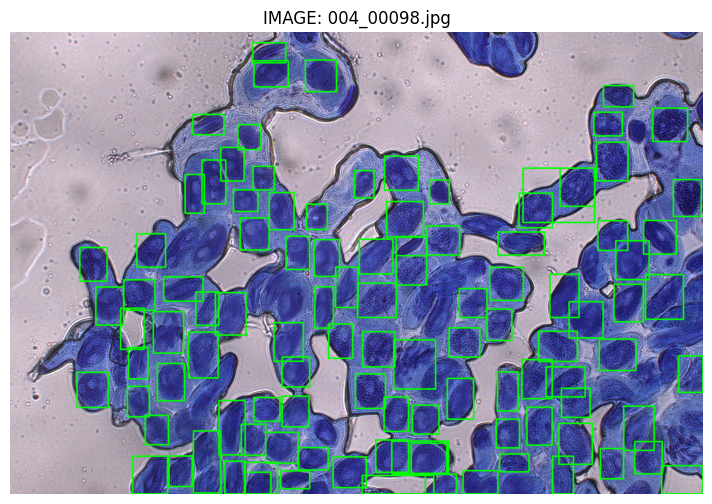

In [33]:
# Read the image
img = cv.imread(IMAGE_PATH)

# Iterate through the DataFrame rows
for _, row in df_bbox.iterrows():
    if row['is_cell']:
        x, y, w, h = int(row['x']), int(row['y']), int(row['w']), int(row['h'])
        # Draw rectangle: (image, (x1, y1), (x2, y2), color, thickness)
        cv.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 5)

plt.figure(figsize=(10, 6))
plt.imshow(img)
plt.axis('off')
plt.title(f"IMAGE: {IMAGE_TO_TEST}")
plt.show()


### Delete test files

In [34]:
shutil.rmtree(TEST_PATH)